## Optimizers

### 1. SGD

$$\theta := \theta - \eta \nabla_{\theta} L(\theta)$$

### 2. Momentum

v means velocity.

$$v := \alpha v - \eta \nabla_{\theta} L(\theta)$$
$$\theta := \theta + v$$

In [18]:
import numpy as np

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None: # init
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### 3. Adagrad

"Learning rate decay"



larger updated value -> smaller learning rate

$$g_t = \nabla_{\theta} L(\theta_t)$$

$$G_t = G_{t-1} + g_t \odot g_t$$

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t} + \epsilon} \odot g_t$$

at some time, update value becomes 0..


RMSProp: forget past gradient, recent gradient affects more ~ like EMA!

In [19]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h == None:
            self.h = {}
            for key, value in params.items():
                self.h[key] = np.zeros_like(value)

        for key, value, in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 4. Adam

mixture of Adagrad & Momentum


" Some of Adam’s advantages are that the magnitudes of parameter updates are invariant to


rescaling of the gradient, its stepsizes are approximately bounded by the stepsize hyperparameter,


it does not require a stationary objective, it works with sparse gradients, and it naturally performs a


form of step size annealing.
"

In [20]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

Adam implementation from original paper:

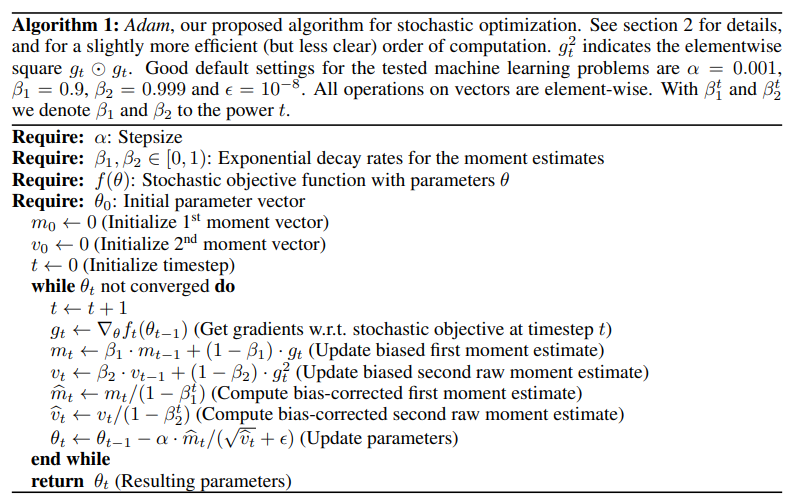

Optimizers...

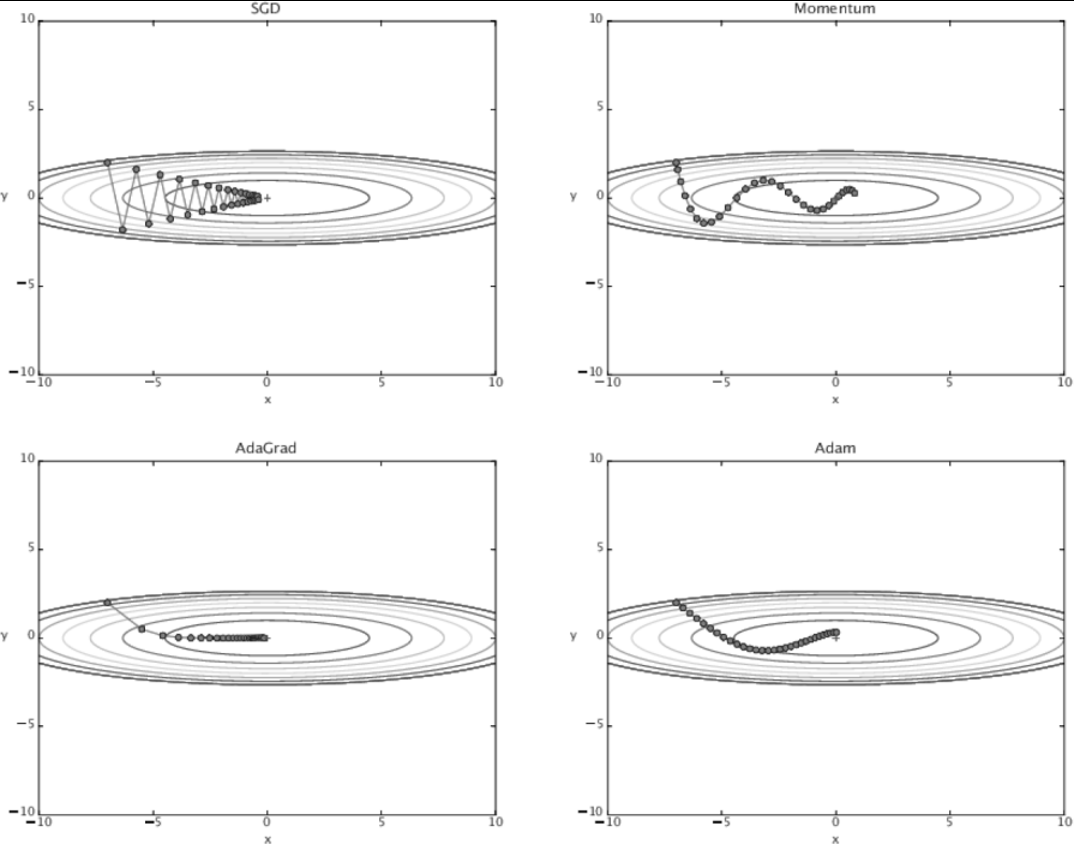

## Initial value of params

If initial value of params are all 0:


all neurons make same output -> can't train!


so..
#### 1. Normal distribution
#### 2. Xavier initialization
#### 3. He initialization

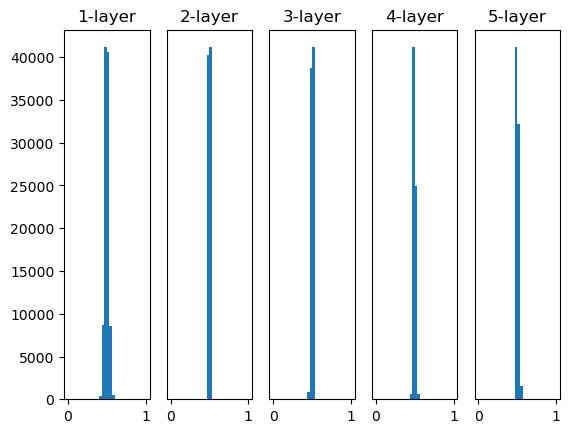

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# activation functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
######################################################
input_data = np.random.randn(1000, 100)  
node_num = 100  
hidden_layer_size = 5 
activations = {}  

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # w = np.random.randn(node_num, node_num) * 1

    w = np.random.randn(node_num, node_num) * 0.01

    # Xavier Initialization ~ sigmoid, tanh
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)

    # He Initialization ~ ReLU
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)

    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

sigmoid output is near 0 or 1 -> gradient is near 0.


"Gradient vanishing"


and.. if sd is small(0.01), outputs are flock to certain value.


it limits expresiveness!


#### so, values should be spread out evenly.

## Batch Normalization

Pros:
1. Fast train speed
2. Less rely on initial value
3. Limit overfitting


How?


#### Affine -> "Batch Normalization" -> Activation Function


by making values -> Standard Normal Distribution

$$\mu_\beta = \frac{1}{m}\sum_{i=1}^{m}x_i$$
$$\sigma_\beta^2 = \frac{1}{m}\sum_{i=1}^{m}(x_i-\mu_\beta)^2$$
$$x_i = \frac{x_i-\mu_\beta}{\sqrt{\sigma_\beta^2+\epsilon}}$$


and, apply "scale", "shift" conversion.

$$y_i = \gamma x_i + \beta$$


### Backpropagation of Batch Normalization

https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

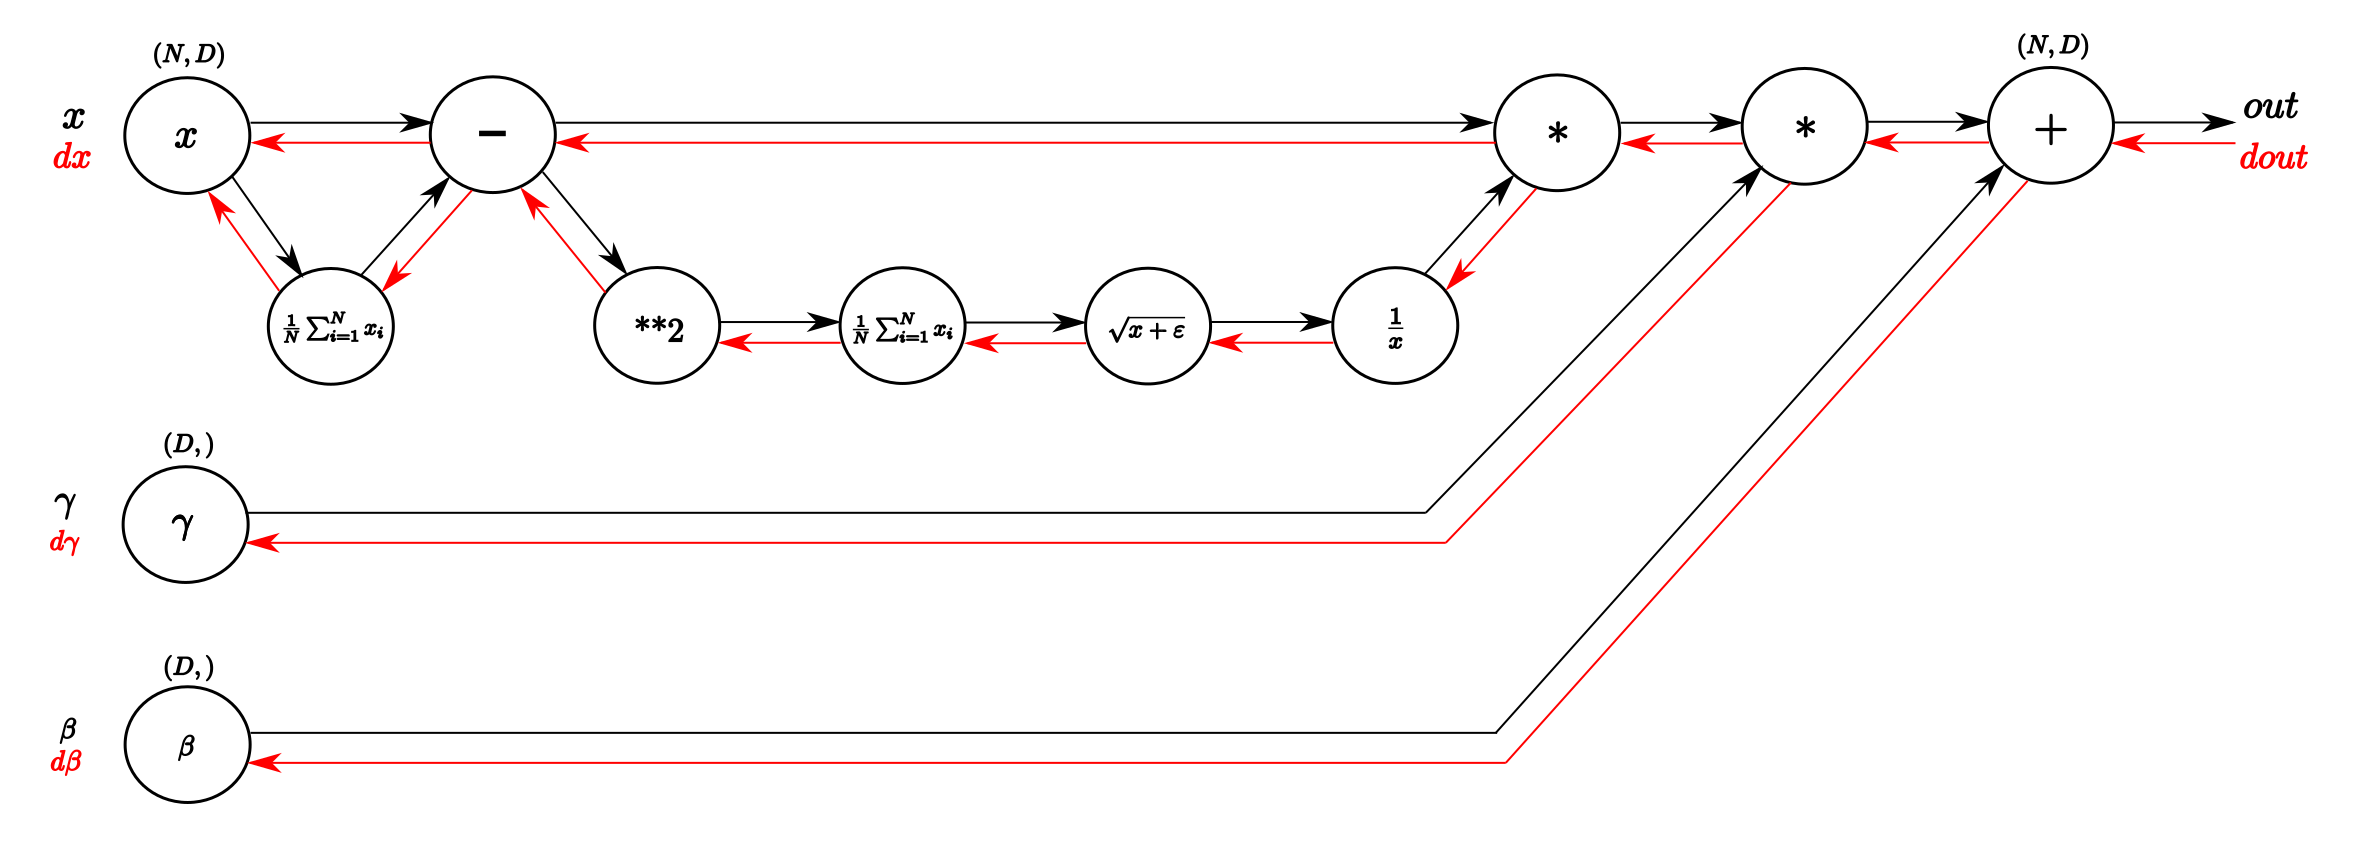

In [ ]:
def batchnorm_backward(dout, cache):

  #unfold the variables stored in cache
  xhat,gamma,xmu,ivar,sqrtvar,var,eps = cache

  #get the dimensions of the input/output
  N,D = dout.shape

  #step9
  dbeta = np.sum(dout, axis=0)
  dgammax = dout #not necessary, but more understandable

  #step8
  dgamma = np.sum(dgammax*xhat, axis=0)
  dxhat = dgammax * gamma

  #step7
  divar = np.sum(dxhat*xmu, axis=0)
  dxmu1 = dxhat * ivar

  #step6
  dsqrtvar = -1. /(sqrtvar**2) * divar

  #step5
  dvar = 0.5 * 1. /np.sqrt(var+eps) * dsqrtvar

  #step4
  dsq = 1. /N * np.ones((N,D)) * dvar

  #step3
  dxmu2 = 2 * xmu * dsq

  #step2
  dx1 = (dxmu1 + dxmu2)
  dmu = -1 * np.sum(dxmu1+dxmu2, axis=0)

  #step1
  dx2 = 1. /N * np.ones((N,D)) * dmu

  #step0
  dx = dx1 + dx2

  return dx, dgamma, dbeta

## Overfitting Issue

### Weight decay

L2 norm and L1 norm.

$$L2 norm = \sqrt{w_1^2 + w_2^2 + ..}$$

$$L1 norm = |w_1|+|w_2|+...$$

this prevents the size of parameters.


### Dropout

Intentionally deletes some nodes.


In [ ]:
class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg = True):
        # train_flg is True if we're on training,
        # False if we're on testing.
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            '''
            [[0.2, 0.9, 0.1, 0.7],
            [0.5, 0.3, 0.8, 0.4],
            [0.9, 0.6, 0.05, 0.2]]

            dropout_ratio = 0.5, so

            mask =
            [[False, True, False, True],
            [False, False, True, False],
            [True, True, False, False]]

            so x * self.mask = 

            [[0.0, 0.9, 0.0, 0.7],
            [0.0, 0.0, 0.8, 0.0],
            [0.9, 0.6, 0.0, 0.0]]
            '''
            return x * self.mask
        else:
            # manipulate size. 
            return x * (1.0 - self.dropout_ratio)
        
        
    def backward(self, dout):
        return dout * self.mask 

Dropout method acts like "ensemble learning".

## Finding Hyperparameters

### ((Caution))

**hyperparameter testing should be held by validation data, not training data. (overfitting)**


It is known that.. Random sampling is better than grid searching.


Also, it is known that.. log scaling is effective. 